In [ ]:
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score,log_loss,f1_score
from sklearn.utils import shuffle
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
sns.set()
sns.color_palette("rocket_r")
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 1000)
df=pd.read_csv('/Users/helloworld/Downloads/fetal_health.csv')
df['fetal_health']=df['fetal_health'].astype(str)
df['fetal_health']=df['fetal_health'].str.replace('1','0')
df['fetal_health']=df['fetal_health'].str.replace('2','1')
df['fetal_health']=df['fetal_health'].str.replace('3','2')
#sklearn.datasets.load_wine(*, return_X_y=False, as_frame=False)
df['fetal_health']=df['fetal_health'].astype(float)
df['fetal_health']=df['fetal_health'].astype(int)
# 定义评价函数
def evaluatescore(x):
    dftarget=df['fetal_health']
    dfdata=df.drop('fetal_health',axis=1)
    X_train, X_test, y_train, y_test = train_test_split(dfdata,dftarget,test_size=0.2)
    y_pred=np.zeros((len(X_test),3))
    data=pd.concat([X_train,y_train],axis=1)
    for i in range(0,5):
        clas1=data[data['fetal_health']==0]
        clas2=data[data['fetal_health']==1]
        clas3=data[data['fetal_health']==2]
        a=clas1.sample(frac=x[i*3])
        b=clas2.sample(frac=x[i*3+1])
        c=clas3.sample(frac=x[i*3+2])
        df1=shuffle(pd.concat([a,b,c]))
        y_train=df1['fetal_health']
        X_train=df1.drop('fetal_health',axis=1)
        # 转换为Dataset数据格式
        train_data = lgb.Dataset(X_train, label=y_train)
        validation_data = lgb.Dataset(X_test, label=y_test)
        params = {
            'learning_rate': 0.1,
            'lambda_l1': 0.1,
            'lambda_l2': 0.2,
            'max_depth': 4,
            'objective': 'multiclass',  # 目标函数
            'num_class': 3,
        }
        gbm = lgb.train(params, train_data, valid_sets=[validation_data])
        y_pred = y_pred+gbm.predict(X_test)*x[15+i]
        
    
    #y_pred = [list(z).index(max(z)) for z in y_pred]
    return log_loss(y_test, y_pred),

from deap import base
from deap import creator
from deap import tools
import random
import matplotlib.pyplot as plt
#超参数声明
ONE_MAX_LENGTH = 20    #length of bit string to be optimized
POPULATION_SIZE = 200   #number of individuals in population
P_CROSSOVER = 0.9       #probability for crossover
P_MUTATION = 0.1        #probability for mutating an individual
MAX_GENERATION = 50     #max number of generations for stopping condition
toolbox = base.Toolbox()#定义toolbox变量
toolbox.register('Attr_float', random.random)
creator.create("FitnessMax",base.Fitness,weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)
toolbox.register("individualCreator",tools.initRepeat,creator.Individual,toolbox.Attr_float,n=ONE_MAX_LENGTH)
toolbox.register("populationCreator",tools.initRepeat,list,toolbox.individualCreator)

toolbox.register("evaluate",evaluatescore)
toolbox.register("select",tools.selTournament,tournsize=3)
toolbox.register("mate",tools.cxOnePoint)
# mutFlipBit函数遍历个体的所有特征，并且对于每个特征值，
# 都将使用indpb参数值作为翻转（应用not运算符）该特征值的概率。
# 该值与突变概率无关，后者由P_MUTATION常数设置。
# 突变概率用于确定是否为种群中的给定个体调用mutFlipBit函数
toolbox.register("mutate",tools.mutFlipBit,indpb=1.0/ONE_MAX_LENGTH)




def main():
    population = toolbox.populationCreator(n=POPULATION_SIZE)
    generationCounter = 0
    fitnessValues = list(map(toolbox.evaluate,population))

    for individual,fitnessValue in zip(population,fitnessValues):
        individual.fitness.values = fitnessValue

    fitnessValues = [individual.fitness.values[0] for individual in population]

    maxFitnessValues = []
    meanFitnessValues = []

    while max(fitnessValues) < ONE_MAX_LENGTH and generationCounter < MAX_GENERATION:
        generationCounter = generationCounter + 1
        
        offspring = toolbox.select(population,len(population))
        offspring = list(map(toolbox.clone,offspring))

        for child1,child2 in zip(offspring[::2],offspring[1::2]):
            if random.random() < P_CROSSOVER:
                toolbox.mate(child1,child2)
                del child1.fitness.values
                del child2.fitness.values
        
        for mutant in offspring:
            if random.random() < P_MUTATION:
                toolbox.mutate(mutant)
                del mutant.fitness.values
        
        freshIndividuals = [ind for ind in offspring if not ind.fitness.valid]
        freshFitnessValues = list(map(toolbox.evaluate,freshIndividuals))
        for individual,fitnessValue in zip(freshIndividuals,freshFitnessValues):
            individual.fitness.values = fitnessValue
        
        population[:] = offspring

        fitnessValues = [ind.fitness.values[0] for ind in population]

        maxFitnessValue = max(fitnessValues)
        meanFitnessValue = sum(fitnessValues) / len(population)
        maxFitnessValues.append(maxFitnessValue)
        meanFitnessValues.append(meanFitnessValue)
        print("- Generation {}: Max Fitness = {}, Avg Fitness = {}".format(generationCounter,maxFitnessValue,meanFitnessValue))

        best_index = fitnessValues.index(max(fitnessValues))
        print("Best Indivadual = ", *population[best_index],"\n")

    plt.plot(maxFitnessValues,color="red")
    plt.plot(meanFitnessValues,color="green")
    plt.xlabel("Generation")
    plt.ylabel("Max / Average Fitness")
    plt.title("Max and Average fitness over Generation")
    plt.show()


main()

- Generation 1: Max Fitness = 11.30115466255414, Avg Fitness = 8.788517282011247
Best Indivadual =  0.9686573058876864 0.0056589713386397955 0.8499687423502582 0.8793487824762217 0.6250648706830962 0.13217511155823713 0.28496322263241647 0.5583320482648009 0.0702229754514031 0.44444884663540263 0.7191045660340599 0.8711643761056908 0.8917165931418002 0.25824919178694183 0.8067791983502387 0.9349884476434152 0.21135186907274062 0.4744149783538779 0.6413164050731157 0.6732281597140953 

- Generation 2: Max Fitness = 10.291442744144511, Avg Fitness = 7.762491738126929
Best Indivadual =  0.8706635559788071 0.27661184832437835 0.9102441642835688 0.8938081284674567 0.026976313572823374 0.04952677671126893 0.6681553480883223 0.789210389484186 0.456926345609879 0.5956723627374577 0.2512255575082152 0.6743955188464515 0.016703150945734935 0.9349434476422451 0.7150129220036858 0.5554211317220927 0.012453558127757725 0.010968073440996706 0.8635099898296907 0.719014160819494 

- Generation 3: Max 

- Generation 22: Max Fitness = 2.5985587823145715, Avg Fitness = 0.5269394933988233
Best Indivadual =  0.0 1.0 0.0 0.12721164277285835 0.13880046264824153 0.0 0.0 0.0 0.0 0.053958763050860115 0.0 0.0 1.0 0.03269383801615544 0.0 0.0797698450916583 0.0493718950395019 0.11675233569529553 0.0 0.0 

- Generation 23: Max Fitness = 1.5118274559922278, Avg Fitness = 0.4375216478646562
Best Indivadual =  0.0 0.0 0.0 0.0 0.13880046264824153 0.0 0.0 0.0 0.0 0.053958763050860115 0.0 1.0 0.0 0.056149153854867184 0.0 0.0797698450916583 0.0493718950395019 0.11675233569529553 0.0015315774066944066 0.015493423205108825 

- Generation 24: Max Fitness = 2.3809265214262885, Avg Fitness = 0.46100335254439023
Best Indivadual =  0.0 0.0 0.0 0.0 0.13880046264824153 0.0 0.0 0.0 1.0 0.053958763050860115 0.0 0.0 0.0 1.0 0.0 0.0 0.05438995942008773 0.11675233569529553 0.0015315774066944066 0.015493423205108825 

- Generation 25: Max Fitness = 2.3477435471900003, Avg Fitness = 0.3907027657839938
Best Indivadual = 

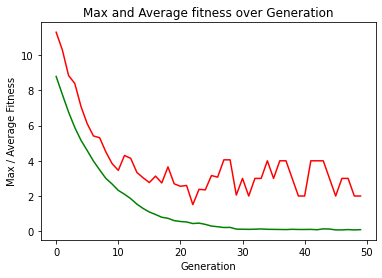

In [1]:
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score,log_loss,f1_score
from sklearn.utils import shuffle
from deap import base
from deap import creator
from deap import tools
import random
import matplotlib.pyplot as plt
#超参数声明
def oneMaxFitness(individual):
    return sum(individual),
ONE_MAX_LENGTH = 20    #length of bit string to be optimized
POPULATION_SIZE = 200   #number of individuals in population
P_CROSSOVER = 0.9       #probability for crossover
P_MUTATION = 0.1        #probability for mutating an individual
MAX_GENERATION = 50     #max number of generations for stopping condition
toolbox = base.Toolbox()#定义toolbox变量
toolbox.register('Attr_float', random.random)
creator.create("FitnessMin",base.Fitness,weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)
toolbox.register("individualCreator",tools.initRepeat,creator.Individual,toolbox.Attr_float,n=ONE_MAX_LENGTH)
toolbox.register("populationCreator",tools.initRepeat,list,toolbox.individualCreator)

toolbox.register("evaluate",oneMaxFitness)
toolbox.register("select",tools.selTournament,tournsize=3)
toolbox.register("mate",tools.cxOnePoint)
# mutFlipBit函数遍历个体的所有特征，并且对于每个特征值，
# 都将使用indpb参数值作为翻转（应用not运算符）该特征值的概率。
# 该值与突变概率无关，后者由P_MUTATION常数设置。
# 突变概率用于确定是否为种群中的给定个体调用mutFlipBit函数
toolbox.register("mutate",tools.mutFlipBit,indpb=1.0/ONE_MAX_LENGTH)




def main():
    population = toolbox.populationCreator(n=POPULATION_SIZE)
    generationCounter = 0
    fitnessValues = list(map(toolbox.evaluate,population))

    for individual,fitnessValue in zip(population,fitnessValues):
        individual.fitness.values = fitnessValue

    fitnessValues = [individual.fitness.values[0] for individual in population]

    maxFitnessValues = []
    meanFitnessValues = []

    while max(fitnessValues) < ONE_MAX_LENGTH and generationCounter < MAX_GENERATION:
        generationCounter = generationCounter + 1
        
        offspring = toolbox.select(population,len(population))
        offspring = list(map(toolbox.clone,offspring))

        for child1,child2 in zip(offspring[::2],offspring[1::2]):
            if random.random() < P_CROSSOVER:
                toolbox.mate(child1,child2)
                del child1.fitness.values
                del child2.fitness.values
        
        for mutant in offspring:
            if random.random() < P_MUTATION:
                toolbox.mutate(mutant)
                del mutant.fitness.values
        
        freshIndividuals = [ind for ind in offspring if not ind.fitness.valid]
        freshFitnessValues = list(map(toolbox.evaluate,freshIndividuals))
        for individual,fitnessValue in zip(freshIndividuals,freshFitnessValues):
            individual.fitness.values = fitnessValue
        
        population[:] = offspring

        fitnessValues = [ind.fitness.values[0] for ind in population]

        maxFitnessValue = max(fitnessValues)
        meanFitnessValue = sum(fitnessValues) / len(population)
        maxFitnessValues.append(maxFitnessValue)
        meanFitnessValues.append(meanFitnessValue)
        print("- Generation {}: Max Fitness = {}, Avg Fitness = {}".format(generationCounter,maxFitnessValue,meanFitnessValue))

        best_index = fitnessValues.index(max(fitnessValues))
        print("Best Indivadual = ", *population[best_index],"\n")

    plt.plot(maxFitnessValues,color="red")
    plt.plot(meanFitnessValues,color="green")
    plt.xlabel("Generation")
    plt.ylabel("Max / Average Fitness")
    plt.title("Max and Average fitness over Generation")
    plt.show()


main()

array([0.28140279, 0.2409828 , 0.32937182, 0.73645238, 0.55769997,
       0.52639029, 0.1541796 , 0.80699805, 0.32072539, 0.90729977])

In [ ]:
import numpy as np
import pandas as pd
import pickle,random
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score,log_loss,f1_score
from sklearn.utils import shuffle
from deap import base
from deap import creator
from deap import tools
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
sns.set()
sns.color_palette("rocket_r")
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 1000)
def softmax(z):
    return np.exp(z)/sum(np.exp(z))

df=pd.read_csv('/Users/helloworld/Desktop/bioinformation/fetal_health.csv')
df['fetal_health']=df['fetal_health'].astype(str)
df['fetal_health']=df['fetal_health'].str.replace('1','0')
df['fetal_health']=df['fetal_health'].str.replace('2','1')
df['fetal_health']=df['fetal_health'].str.replace('3','2')
#sklearn.datasets.load_wine(*, return_X_y=False, as_frame=False)
df['fetal_health']=df['fetal_health'].astype(float)
df['fetal_health']=df['fetal_health'].astype(int)
# 定义评价函数
def evaluatescore(x):
    wei=softmax(x[15:20])
    dftarget=df['fetal_health']
    dfdata=df.drop('fetal_health',axis=1)
    X_train, X_test, y_train, y_test = train_test_split(dfdata,dftarget,test_size=0.2)
    y_pred=np.zeros((len(X_test),3))
    data=pd.concat([X_train,y_train],axis=1)
    for i in range(0,5):
        clas1=data[data['fetal_health']==0]
        clas2=data[data['fetal_health']==1]
        clas3=data[data['fetal_health']==2]
        a=clas1.sample(frac=x[i*3])
        b=clas2.sample(frac=x[i*3+1])
        c=clas3.sample(frac=x[i*3+2])
        df1=shuffle(pd.concat([a,b,c]))
        y_train=df1['fetal_health']
        X_train=df1.drop('fetal_health',axis=1)
        # 转换为Dataset数据格式
        train_data = lgb.Dataset(X_train, label=y_train)
        validation_data = lgb.Dataset(X_test, label=y_test)
        params = {
            'learning_rate': 0.1,
            'lambda_l1': 0.1,
            'lambda_l2': 0.2,
            'max_depth': 4,
            'objective': 'multiclass',  # 目标函数
            'num_class': 3,
        }
        gbm = lgb.train(params, train_data, valid_sets=[validation_data])
        y_pred = y_pred+gbm.predict(X_test)*wei[i]
        
    
    #y_pred = [list(z).index(max(z)) for z in y_pred]
    return log_loss(y_test, y_pred),

ONE_MAX_LENGTH = 20    #length of bit string to be optimized
POPULATION_SIZE = 20   #number of individuals in population
P_CROSSOVER = 0.9       #probability for crossover
P_MUTATION = 0.1        #probability for mutating an individual
MAX_GENERATION = 20     #max number of generations for stopping condition
toolbox = base.Toolbox()#定义toolbox变量
toolbox.register('Attr_float', random.random)
creator.create("FitnessMin",base.Fitness,weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)
toolbox.register("individualCreator",tools.initRepeat,creator.Individual,toolbox.Attr_float,n=ONE_MAX_LENGTH)
toolbox.register("populationCreator",tools.initRepeat,list,toolbox.individualCreator)

toolbox.register("evaluate",evaluatescore)
toolbox.register("select",tools.selTournament,tournsize=3)
toolbox.register("mate",tools.cxOnePoint)
# mutFlipBit函数遍历个体的所有特征，并且对于每个特征值，
# 都将使用indpb参数值作为翻转（应用not运算符）该特征值的概率。
# 该值与突变概率无关，后者由P_MUTATION常数设置。
# 突变概率用于确定是否为种群中的给定个体调用mutFlipBit函数
toolbox.register("mutate",tools.mutFlipBit,indpb=1.0/ONE_MAX_LENGTH)




def main():
    population = toolbox.populationCreator(n=POPULATION_SIZE)
    generationCounter = 0
    fitnessValues = list(map(toolbox.evaluate,population))

    for individual,fitnessValue in zip(population,fitnessValues):
        individual.fitness.values = fitnessValue

    fitnessValues = [individual.fitness.values[0] for individual in population]

    maxFitnessValues = []
    meanFitnessValues = []

    while max(fitnessValues) < ONE_MAX_LENGTH and generationCounter < MAX_GENERATION:
        generationCounter = generationCounter + 1
        
        offspring = toolbox.select(population,len(population))
        offspring = list(map(toolbox.clone,offspring))

        for child1,child2 in zip(offspring[::2],offspring[1::2]):
            if random.random() < P_CROSSOVER:
                toolbox.mate(child1,child2)
                del child1.fitness.values
                del child2.fitness.values
        
        for mutant in offspring:
            if random.random() < P_MUTATION:
                toolbox.mutate(mutant)
                del mutant.fitness.values
        
        freshIndividuals = [ind for ind in offspring if not ind.fitness.valid]
        freshFitnessValues = list(map(toolbox.evaluate,freshIndividuals))
        for individual,fitnessValue in zip(freshIndividuals,freshFitnessValues):
            individual.fitness.values = fitnessValue
        
        population[:] = offspring

        fitnessValues = [ind.fitness.values[0] for ind in population]

        maxFitnessValue = max(fitnessValues)
        meanFitnessValue = sum(fitnessValues) / len(population)
        maxFitnessValues.append(maxFitnessValue)
        meanFitnessValues.append(meanFitnessValue)
        print("- Generation {}: Max Fitness = {}, Avg Fitness = {}".format(generationCounter,maxFitnessValue,meanFitnessValue))

        best_index = fitnessValues.index(max(fitnessValues))
        print("Best Indivadual = ", *population[best_index],"\n")

    plt.plot(maxFitnessValues,color="red")
    plt.plot(meanFitnessValues,color="green")
    plt.xlabel("Generation")
    plt.ylabel("Max / Average Fitness")
    plt.title("Max and Average fitness over Generation")
    plt.show()


main()

In [ ]:
import numpy as np
import pandas as pd
import pickle,random
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score,log_loss,f1_score
from sklearn.utils import shuffle
from deap import base
from deap import creator
from deap import tools
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
sns.set()
sns.color_palette("rocket_r")
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 1000)
def softmax(z):
    return np.exp(z)/sum(np.exp(z))

df=pd.read_csv('/Users/helloworld/Desktop/bioinformation/fetal_health.csv')
df['fetal_health']=df['fetal_health'].astype(str)
df['fetal_health']=df['fetal_health'].str.replace('1','0')
df['fetal_health']=df['fetal_health'].str.replace('2','1')
df['fetal_health']=df['fetal_health'].str.replace('3','2')
#sklearn.datasets.load_wine(*, return_X_y=False, as_frame=False)
df['fetal_health']=df['fetal_health'].astype(float)
df['fetal_health']=df['fetal_health'].astype(int)
x=np.random.rand(20)
wei=softmax(x[15:20])
dftarget=df['fetal_health']
dfdata=df.drop('fetal_health',axis=1)
X_train, X_test, y_train, y_test = train_test_split(dfdata,dftarget,test_size=0.2)
y_pred=np.zeros((len(X_test),3))
data=pd.concat([X_train,y_train],axis=1)
for i in range(0,5):
    clas1=data[data['fetal_health']==0]
    clas2=data[data['fetal_health']==1]
    clas3=data[data['fetal_health']==2]
    a=clas1.sample(frac=x[i*3])
    b=clas2.sample(frac=x[i*3+1])
    c=clas3.sample(frac=x[i*3+2])
    df1=shuffle(pd.concat([a,b,c]))
    y_train=df1['fetal_health']
    X_train=df1.drop('fetal_health',axis=1)
    # 转换为Dataset数据格式
    train_data = lgb.Dataset(X_train, label=y_train)
    validation_data = lgb.Dataset(X_test, label=y_test)
    params = {
        'learning_rate': 0.1,
        'lambda_l1': 0.1,
        'lambda_l2': 0.2,
        'max_depth': 4,
        'objective': 'multiclass',  # 目标函数
        'num_class': 3,
    }
    gbm = lgb.train(params, train_data, valid_sets=[validation_data])
    y_pred = y_pred+gbm.predict(X_test)*wei[i]
    #y_pred = y_pred+gbm.predict(X_test)*x[15+i]


In [ ]:
print(np.sum(y_pred,axis=1,keepdims=True))

In [4]:
import numpy as np
x=np.random.rand(20)